<a href="https://colab.research.google.com/github/mdsiam135/thesis_2025/blob/main/DenseNet(5_labels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# ========================================
# STEP 1: Import Required Libraries
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.18.0


In [16]:

# ========================================
# STEP 2: Define DenseNet Class
# ========================================

class DenseNetTabular:
    def __init__(self, input_dim, num_classes=5):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.model = None
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.history = None

    def create_dense_block(self, x, growth_rate, num_layers, name):
        """Create a dense block with specified growth rate and number of layers"""
        for i in range(num_layers):
            # Batch normalization and ReLU activation
            bn = layers.BatchNormalization(name=f'{name}_bn_{i}')(x)
            relu = layers.ReLU(name=f'{name}_relu_{i}')(bn)

            # Dense layer with growth rate
            conv = layers.Dense(growth_rate, name=f'{name}_dense_{i}')(relu)

            # Concatenate with input (skip connection)
            x = layers.Concatenate(name=f'{name}_concat_{i}')([x, conv])

        return x

    def create_transition_layer(self, x, compression_factor, name):
        """Create transition layer for dimensionality reduction"""
        # Get number of features
        num_features = x.shape[-1]

        # Batch normalization and ReLU
        bn = layers.BatchNormalization(name=f'{name}_bn')(x)
        relu = layers.ReLU(name=f'{name}_relu')(bn)

        # Compress features
        compressed_features = int(num_features * compression_factor)
        dense = layers.Dense(compressed_features, name=f'{name}_dense')(relu)

        # Dropout for regularization
        dropout = layers.Dropout(0.2, name=f'{name}_dropout')(dense)

        return dropout

    def build_model(self):
        """Build DenseNet architecture for tabular data"""
        # Input layer
        inputs = layers.Input(shape=(self.input_dim,), name='input')

        # Initial dense layer
        x = layers.Dense(64, activation='relu', name='initial_dense')(inputs)
        x = layers.BatchNormalization(name='initial_bn')(x)
        x = layers.Dropout(0.1, name='initial_dropout')(x)

        # Dense Block 1
        x = self.create_dense_block(x, growth_rate=32, num_layers=4, name='dense_block_1')
        x = self.create_transition_layer(x, compression_factor=0.5, name='transition_1')

        # Dense Block 2
        x = self.create_dense_block(x, growth_rate=32, num_layers=4, name='dense_block_2')
        x = self.create_transition_layer(x, compression_factor=0.5, name='transition_2')

        # Dense Block 3
        x = self.create_dense_block(x, growth_rate=32, num_layers=4, name='dense_block_3')

        # Global Average Pooling equivalent for tabular data
        x = layers.BatchNormalization(name='final_bn')(x)
        x = layers.ReLU(name='final_relu')(x)

        # Classification head
        x = layers.Dense(128, activation='relu', name='classifier_dense_1')(x)
        x = layers.Dropout(0.3, name='classifier_dropout_1')(x)
        x = layers.Dense(64, activation='relu', name='classifier_dense_2')(x)
        x = layers.Dropout(0.2, name='classifier_dropout_2')(x)

        # Output layer
        outputs = layers.Dense(self.num_classes, activation='softmax', name='output')(x)

        # Create model
        self.model = keras.Model(inputs=inputs, outputs=outputs, name='DenseNet_Tabular')

        return self.model

    def compile_model(self, learning_rate=0.001):
        """Compile the model with optimizer and loss function"""
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def preprocess_data(self, df, target_column, is_training=True):
        """Preprocess the data for training"""
        # Separate features and target
        X = df.drop(columns=[target_column])
        y = df[target_column]

        if is_training:
            # Create quantile-based labels for training data
            quantiles = y.quantile([0.2, 0.4, 0.6, 0.8])
            labels = []
            for value in y:
                if value <= quantiles[0.2]:
                    labels.append('very_low')
                elif value <= quantiles[0.4]:
                    labels.append('low')
                elif value <= quantiles[0.6]:
                    labels.append('medium')
                elif value <= quantiles[0.8]:
                    labels.append('high')
                else:
                    labels.append('very_high')

            # Store quantiles for later use
            self.quantiles = quantiles

            # Fit label encoder and scaler
            y_encoded = self.label_encoder.fit_transform(labels)
            X_scaled = self.scaler.fit_transform(X)
        else:
            # Use existing quantiles for validation/test data
            labels = []
            for value in y:
                if value <= self.quantiles[0.2]:
                    labels.append('very_low')
                elif value <= self.quantiles[0.4]:
                    labels.append('low')
                elif value <= self.quantiles[0.6]:
                    labels.append('medium')
                elif value <= self.quantiles[0.8]:
                    labels.append('high')
                else:
                    labels.append('very_high')

            # Transform using fitted encoders
            y_encoded = self.label_encoder.transform(labels)
            X_scaled = self.scaler.transform(X)

        # Convert to categorical
        y_categorical = keras.utils.to_categorical(y_encoded, num_classes=self.num_classes)

        return X_scaled, y_categorical, y_encoded, labels

print("DenseNetTabular class defined successfully!")


DenseNetTabular class defined successfully!


In [17]:

# ========================================
# STEP 3: Define Utility Functions
# ========================================

def load_and_preprocess_data():
    """Load and preprocess all datasets"""
    print("Loading datasets...")

    # Load datasets
    train_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/train.csv')
    val_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/validation.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/UpdatedDataset/test.csv')

    print(f"Train dataset shape: {train_df.shape}")
    print(f"Validation dataset shape: {val_df.shape}")
    print(f"Test dataset shape: {test_df.shape}")

    # Check for missing values
    print("\nMissing values in train dataset:")
    print(train_df.isnull().sum().sum())

    # Handle missing values if any
    train_df = train_df.fillna(train_df.mean(numeric_only=True))
    val_df = val_df.fillna(val_df.mean(numeric_only=True))
    test_df = test_df.fillna(test_df.mean(numeric_only=True))

    return train_df, val_df, test_df

def calculate_metrics(y_true, y_pred):
    """Calculate all required metrics"""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'macro_f1': macro_f1
    }

def plot_confusion_matrix(y_true, y_pred, labels, title, save_path=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_training_history(history, save_path=None):
    """Plot training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

print("Utility functions defined successfully!")


Utility functions defined successfully!


In [18]:

# ========================================
# STEP 4: Load and Preprocess Data
# ========================================

print("="*50)
print("STEP 4: Loading and Preprocessing Data")
print("="*50)

train_df, val_df, test_df = load_and_preprocess_data()


STEP 4: Loading and Preprocessing Data
Loading datasets...
Train dataset shape: (3942, 84)
Validation dataset shape: (845, 84)
Test dataset shape: (845, 84)

Missing values in train dataset:
0


In [19]:

# ========================================
# STEP 5: Initialize DenseNet Model
# ========================================

print("\n" + "="*50)
print("STEP 5: Initializing DenseNet Model")
print("="*50)

# Get input dimension (excluding target column)
input_dim = train_df.shape[1] - 1  # Subtract 1 for target column
print(f"Input dimension: {input_dim}")

# Initialize DenseNet
densenet = DenseNetTabular(input_dim=input_dim, num_classes=5)
print("DenseNet model initialized successfully!")



STEP 5: Initializing DenseNet Model
Input dimension: 83
DenseNet model initialized successfully!


In [20]:

# ========================================
# STEP 6: Preprocess Datasets
# ========================================

print("\n" + "="*50)
print("STEP 6: Preprocessing Datasets")
print("="*50)

# Preprocess training data
print("Preprocessing training data...")
X_train, y_train_cat, y_train_encoded, train_labels = densenet.preprocess_data(
    train_df, 'Production (M.Ton)', is_training=True
)

# Preprocess validation data
print("Preprocessing validation data...")
X_val, y_val_cat, y_val_encoded, val_labels = densenet.preprocess_data(
    val_df, 'Production (M.Ton)', is_training=False
)

# Preprocess test data
print("Preprocessing test data...")
X_test, y_test_cat, y_test_encoded, test_labels = densenet.preprocess_data(
    test_df, 'Production (M.Ton)', is_training=False
)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

print("Data preprocessing completed successfully!")



STEP 6: Preprocessing Datasets
Preprocessing training data...
Preprocessing validation data...
Preprocessing test data...
Training data shape: (3942, 83)
Validation data shape: (845, 83)
Test data shape: (845, 83)
Data preprocessing completed successfully!


In [21]:

# ========================================
# STEP 7: Build and Compile Model
# ========================================

print("\n" + "="*50)
print("STEP 7: Building and Compiling Model")
print("="*50)

# Build the model
model = densenet.build_model()
print("Model architecture built successfully!")

# Compile the model
densenet.compile_model(learning_rate=0.001)
print("Model compiled successfully!")

# Display model summary
print("\nModel Architecture:")
model.summary()



STEP 7: Building and Compiling Model
Model architecture built successfully!
Model compiled successfully!

Model Architecture:


Model: "DenseNet_Tabular"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 83)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_dense       │ (None, 64)        │      5,376 │ input[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_bn          │ (None, 64)        │        256 │ initial_dense[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_dropout     │ (None, 64)        │          0 │ initial_bn[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_bn_0  │ (None, 64)        │        256 │ initial_dropout[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_relu… │ (None, 64)        │          0 │ dense_block_1_bn… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_dens… │ (None, 32)        │      2,080 │ dense_block_1_re… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_conc… │ (None, 96)        │          0 │ initial_dropout[… │
│ (Concatenate)       │                   │            │ dense_block_1_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_bn_1  │ (None, 96)        │        384 │ dense_block_1_co… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_relu… │ (None, 96)        │          0 │ dense_block_1_bn… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_dens… │ (None, 32)        │      3,104 │ dense_block_1_re… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_conc… │ (None, 128)       │          0 │ dense_block_1_co… │
│ (Concatenate)       │                   │            │ dense_block_1_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_bn_2  │ (None, 128)       │        512 │ dense_block_1_co… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_relu… │ (None, 128)       │          0 │ dense_block_1_bn… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_dens… │ (None, 32)        │      4,128 │ dense_block_1_re… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_conc… │ (None, 160)       │          0 │ dense_block_1_co… │
│ (Concatenate)       │                   │            │ dense_block_1_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_block_1_bn_3  │ (None, 160)       │        640 │ dense_block_1_co… │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 151,701 (592.58 KB)

 Trainable params: 146,933 (573.96 KB)

 Non-trainable params: 4,768 (18.62 KB)

In [22]:

# ========================================
# STEP 8: Set Up Training Configuration
# ========================================

print("\n" + "="*50)
print("STEP 8: Setting Up Training Configuration")
print("="*50)

# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

# Training parameters
epochs = 50
batch_size = 32

print(f"Training configuration:")
print(f"  - Epochs: {epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Early stopping patience: 10")
print(f"  - Learning rate reduction patience: 5")



STEP 8: Setting Up Training Configuration
Training configuration:
  - Epochs: 50
  - Batch size: 32
  - Early stopping patience: 10
  - Learning rate reduction patience: 5


In [23]:

# ========================================
# STEP 9: Train the Model
# ========================================

print("\n" + "="*50)
print("STEP 9: Training the Model")
print("="*50)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

densenet.history = history
print("\nModel training completed successfully!")



STEP 9: Training the Model
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.2261 - loss: 1.6791 - val_accuracy: 0.4154 - val_loss: 1.4342 - learning_rate: 0.0010
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3278 - loss: 1.4777 - val_accuracy: 0.5195 - val_loss: 1.1539 - learning_rate: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4684 - loss: 1.2404 - val_accuracy: 0.5964 - val_loss: 0.9685 - learning_rate: 0.0010
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5308 - loss: 1.1067 - val_accuracy: 0.6118 - val_loss: 0.8947 - learning_rate: 0.0010
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5750 - loss: 1.0001 - val_accuracy: 0.6462 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6202 - loss: 0.9262 - val_accuracy: 0.6734 - val_loss: 0.7704 - learning_rate: 0.0010
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 

In [24]:

# ========================================
# STEP 10: Evaluate on Validation Set
# ========================================

print("\n" + "="*50)
print("STEP 10: Validation Set Evaluation")
print("="*50)

# Predictions on validation set
val_pred_probs = model.predict(X_val)
val_pred_encoded = np.argmax(val_pred_probs, axis=1)

# Calculate metrics for validation
val_metrics = calculate_metrics(y_val_encoded, val_pred_encoded)

print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")



STEP 10: Validation Set Evaluation
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Validation Metrics:
Accuracy: 0.8556
Precision: 0.8559
Recall: 0.8556
F1 Score: 0.8542
Macro F1: 0.8512


In [25]:

# ========================================
# STEP 11: Evaluate on Test Set
# ========================================

print("\n" + "="*50)
print("STEP 11: Test Set Evaluation")
print("="*50)

# Predictions on test set
test_pred_probs = model.predict(X_test)
test_pred_encoded = np.argmax(test_pred_probs, axis=1)

# Calculate metrics for test
test_metrics = calculate_metrics(y_test_encoded, test_pred_encoded)

print("Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")



STEP 11: Test Set Evaluation
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Metrics:
Accuracy: 0.8225
Precision: 0.8247
Recall: 0.8225
F1 Score: 0.8224
Macro F1: 0.8219



STEP 12: Creating Visualizations
Plotting training history...


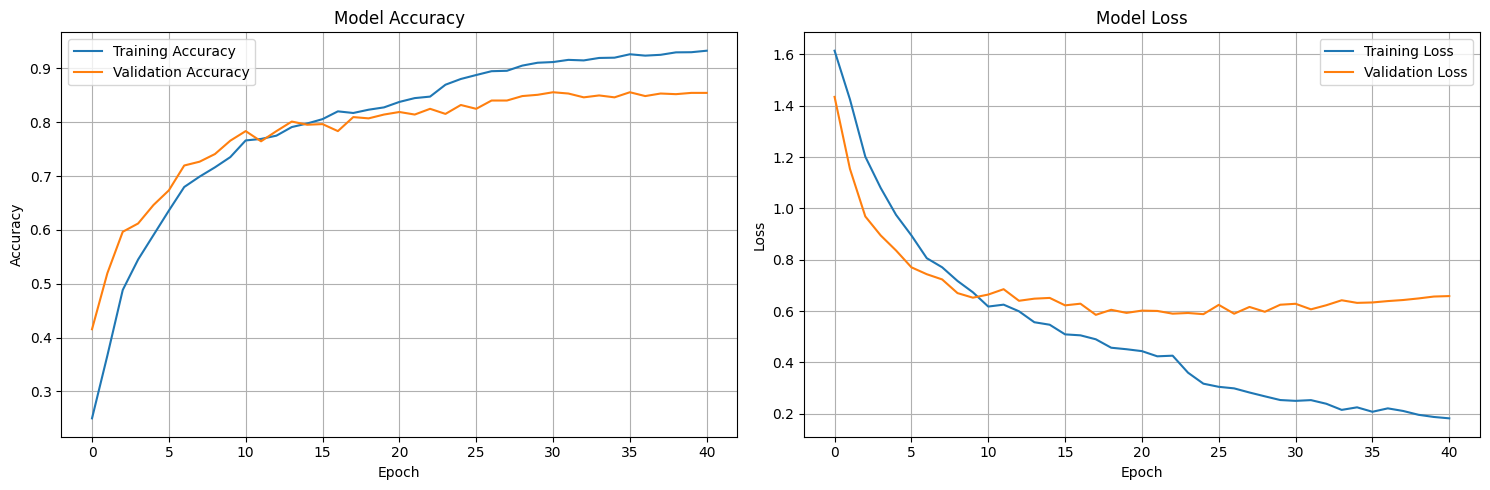

Plotting confusion matrix for validation...


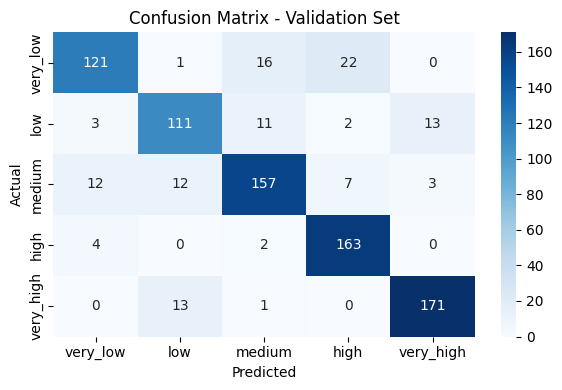

Plotting confusion matrix for test...


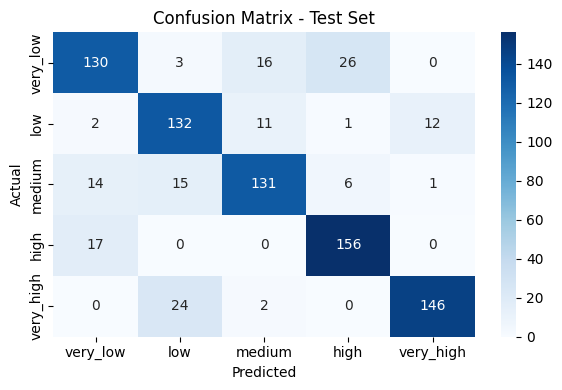

In [26]:

# ========================================
# STEP 12: Create Visualizations
# ========================================

print("\n" + "="*50)
print("STEP 12: Creating Visualizations")
print("="*50)

# Class labels
class_labels = ['very_low', 'low', 'medium', 'high', 'very_high']

# Plot training history
print("Plotting training history...")
plot_training_history(history)

# Plot confusion matrix for validation
print("Plotting confusion matrix for validation...")
plot_confusion_matrix(
    y_val_encoded, val_pred_encoded,
    class_labels,
    'Confusion Matrix - Validation Set'
)

# Plot confusion matrix for test
print("Plotting confusion matrix for test...")
plot_confusion_matrix(
    y_test_encoded, test_pred_encoded,
    class_labels,
    'Confusion Matrix - Test Set'
)


In [27]:

# ========================================
# STEP 13: Detailed Classification Reports
# ========================================

print("\n" + "="*50)
print("STEP 13: Detailed Classification Reports")
print("="*50)

print("Validation Classification Report:")
print(classification_report(y_val_encoded, val_pred_encoded,
                          target_names=class_labels))

print("\nTest Classification Report:")
print(classification_report(y_test_encoded, test_pred_encoded,
                          target_names=class_labels))



STEP 13: Detailed Classification Reports
Validation Classification Report:
              precision    recall  f1-score   support

    very_low       0.86      0.76      0.81       160
         low       0.81      0.79      0.80       140
      medium       0.84      0.82      0.83       191
        high       0.84      0.96      0.90       169
   very_high       0.91      0.92      0.92       185

    accuracy                           0.86       845
   macro avg       0.85      0.85      0.85       845
weighted avg       0.86      0.86      0.85       845


Test Classification Report:
              precision    recall  f1-score   support

    very_low       0.80      0.74      0.77       175
         low       0.76      0.84      0.80       158
      medium       0.82      0.78      0.80       167
        high       0.83      0.90      0.86       173
   very_high       0.92      0.85      0.88       172

    accuracy                           0.82       845
   macro avg       0.82   

In [28]:

# ========================================
# STEP 14: Final Summary
# ========================================

print("\n" + "="*50)
print("STEP 14: Final Summary")
print("="*50)

print("Final Results Summary:")
print(f"Validation Accuracy: {val_metrics['accuracy']:.4f}")
print(f"Validation Macro F1-Score: {val_metrics['macro_f1']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Macro F1-Score: {test_metrics['macro_f1']:.4f}")

print("\nTraining completed successfully!")
print("Model is ready for inference on new data.")

print("All steps completed successfully!")


STEP 14: Final Summary
Final Results Summary:
Validation Accuracy: 0.8556
Validation Macro F1-Score: 0.8512
Test Accuracy: 0.8225
Test Macro F1-Score: 0.8219

Training completed successfully!
Model is ready for inference on new data.
All steps completed successfully!
